## Project: Build classification model to predict cross-sales between health and car insurance

- [1. Introduction](#intro)
- [2. Data Wrangling & Cleaning](#wrangling)
- [3. Exploratory data analysis](#eda)
- [4. Data Pre-processing](#preprocessing)
- [5. Predictive model building](#predictive)
- [6. Feature selection](#featureselection)
- [7. Model Evaluation](#evaluation)
- [8. Conclusion](#conclusion)

<a id='intro'></a>
## 1. Introduction

###### Aims of the projects  

In this project, my aim is to use the insurance company’s historical data to predict whether a policyholder (customer) of their health insurance would like to buy the vehicle insurance. The motivation for the study is from the observation that the features such as demographic statistics, vehicle conditions, and policy-related information, could be helpful to identify the potential customer groups. The main dataset for this project is available on Kaggle: https://www.kaggle.com/datasets/anmolkumar/health-insurance-cross-sell-prediction  

 

 

###### Methods 

- **Exploratory analysis** will be used to make correlation analysis to identify the relationship between the customers’ attributes and our outcome: customer is interested or not interested. For numeric data, the EDA would include some descriptive analysis like histograms or pivot tables for better understanding of the data distributions. For categorical data, the EDA could include heatmaps or bar charts for understanding the balance of classes.  

- **Predictive analysis** would be done to predict the likelihood that customers are willing to buy vehicle insurance using various methods including logistics regression, support vector machine (SVM) and decision tree. After that, I evaluate model performance of those algorithms by testing the receiver operating characteristic (ROC), area under curve (AUC) and confusion matrix. 

<a id='wrangling'></a>
## 2. Data Wrangling & Cleaning

### 2.1. Import Library

In [8]:
import pandas as pd

import numpy as np
import seaborn as sns

import itertools

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.ticker as mtick
import scikitplot as skplt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import pydotplus
from IPython.display import Image

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

from collections import Counter

### 2.2 Import Data

#### 2.2.1. Basic information of the dataset

In [9]:
data = pd.read_csv('data.csv')

In [10]:
data.head(10).style

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.000000,0,> 2 Years,Yes,40454.000000,26.000000,217,1
1,2,Male,76,1,3.000000,0,1-2 Year,No,33536.000000,26.000000,183,0
2,3,Male,47,1,28.000000,0,> 2 Years,Yes,38294.000000,26.000000,27,1
3,4,Male,21,1,11.000000,1,< 1 Year,No,28619.000000,152.000000,203,0
4,5,Female,29,1,41.000000,1,< 1 Year,No,27496.000000,152.000000,39,0
5,6,Female,24,1,33.000000,0,< 1 Year,Yes,2630.000000,160.000000,176,0
6,7,Male,23,1,11.000000,0,< 1 Year,Yes,23367.000000,152.000000,249,0
7,8,Female,56,1,28.000000,0,1-2 Year,Yes,32031.000000,26.000000,72,1
8,9,Female,24,1,3.000000,1,< 1 Year,No,27619.000000,152.000000,28,0
9,10,Female,32,1,6.000000,1,< 1 Year,No,28771.000000,152.000000,80,0


In [11]:
data.shape

(381109, 12)

#### 2.2.2. Data Understanding

| Features | Descriptions
| - - - | - - - |
| id | Unique ID for the customer |
| Gender | Gender of the customer |
| Age | Age of the customer |
| Driving_License | 0 : Customer does not have DL, 1 : Customer already has DL |
| Region_Code | Unique code for the region of the customer |
| Previously_Insured | 1 : Customer already has Vehicle Insurance,0: Customer doesn't have Vehicle Insurance |
| Vehicle_Age | Age of the Vehicle |
| Vehicle_Damage | 1 : Customer got his/her vehicle damaged in the past.0: Customer didn't get his/her vehicle damaged in he past |
| Annual_Premium | The amount customer needs to pay as premium in the year |
| PolicySalesChannel | Anonymised Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc. |
| Vintage | Number of Days, Customer has been associated with the company |
| Response | 1 : Customer is interested, 0 : Customer is not interested |

#### 2.2.3. Check for missing values

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [13]:
data.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

#### Missing value Checking result

There is no missing data of each column in our dataset. 

<a id='eda'></a>
## 3. Exploratory data analysis (EDA)

### 3.1. Descriptive analysis before pre-processing data

In [14]:
data.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


#### Observation:

1. Age range is between 20 to 85. The customers' average age is 38-year-old.
2. 99.8% of customers have driving license.
3. 45% of customers have already bought vihecle insurance.
4. Annual premium range is between 2630 to 540165 and the average annual premium is 30564.
5. Customer has been associated with the company is between 10 to 299 days. The average days of customer associated with company is 154.

### 3.2. Heat Map before pre-processing data

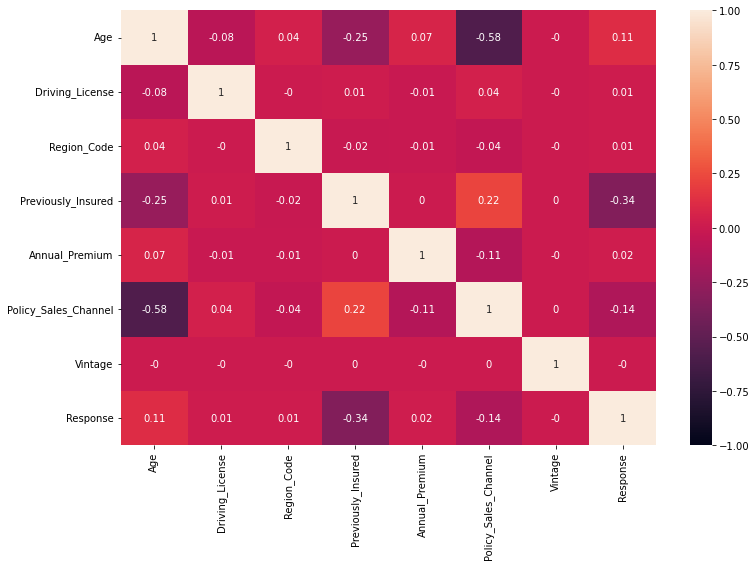

In [16]:
import seaborn as sns

fig = plt.figure(figsize=(12, 8))

dataplot = sns.heatmap(data.iloc[:, 1:].corr().round(2), vmin=-1, vmax=1, annot=True)

plt.show()

##### Observation

Previously_Insured variable is apparently an important features because of its high correlationship with the target 'Response'

### 3.3. Target variable - "Response" column

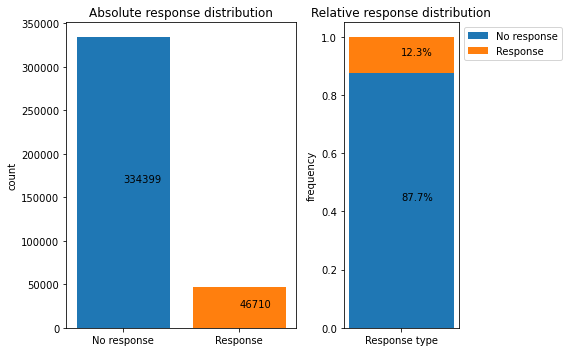

In [17]:
# plot response
keys, counts = np.unique(data.Response, return_counts=True)
counts_norm = counts/counts.sum()

fig = plt.figure(figsize=(8, 5)) #specify figure size
gs = gridspec.GridSpec(1, 2, width_ratios=[2,1]) #specify relative size of left and right plot

#Absolute values
ax0 = plt.subplot(gs[0])
ax0 = plt.bar(['No response', 'Response'], counts, color=['#1f77b4','#ff7f0e']) #left bar plot
ax0 = plt.title('Absolute response distribution') 
ax0 = plt.ylabel('count')
ax0 = plt.text(keys[0], counts[0]/2, counts[0]) #add text box with count of non-fraudulent cases
ax0 = plt.text(keys[1], counts[1]/2, counts[1]) #add text box with count of fraudulent cases

#Normalized values
ax1 = plt.subplot(gs[1])
ax1 = plt.bar(['Response type'], [counts_norm[0]], label='No response')
ax1 = plt.bar(['Response type'], [counts_norm[1]], bottom=counts_norm[0], label='Response')
ax1 = plt.legend(bbox_to_anchor=(1, 1))
ax1 = plt.title('Relative response distribution')
ax1 = plt.ylabel('frequency')
ax1 = plt.text(['Response type'],counts_norm[0]/2, '{}%'.format((counts_norm[0]*100).round(1)))
ax1 = plt.text(['Response type'],(counts_norm[1]/2)+counts_norm[0], '{}%'.format((counts_norm[1]*100).round(1)))

plt.tight_layout()
plt.show()

##### Observation

We found that our database is extremely imbalanced. The number of Non-response cases are far more than the number of Response cases.

It is necessary to conduct the resampling process for the dataset. 

### 3.4. Feature Distribution

#### 3.4.1. Categorical features

#### Objective

We are trying to explore the data distribution of categorical columns, including observing the number of unique values in each columns, and determing whether we should drop some irrelevant columns or creating dummies for variables shown in string format. 

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


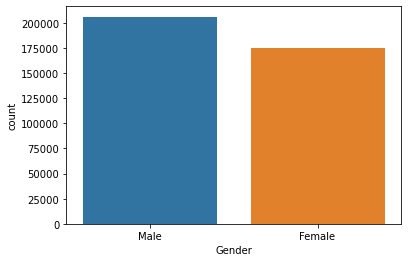

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


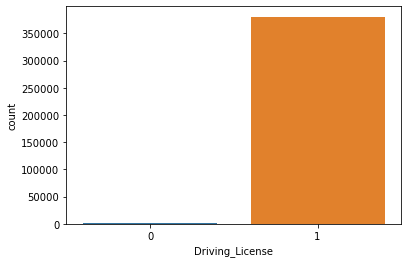

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


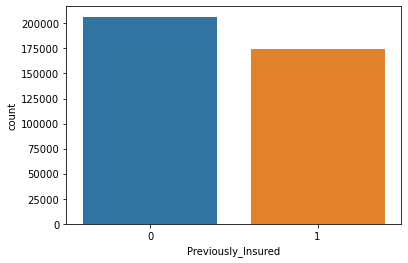

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


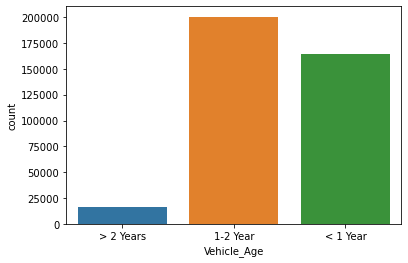

/opt/software/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


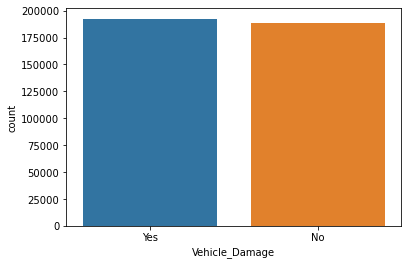

Gender ; 2
Driving_License ; 2
Previously_Insured ; 2
Vehicle_Age ; 3
Vehicle_Damage ; 2


In [81]:
cat_f = ['Gender','Driving_License','Previously_Insured','Vehicle_Age','Vehicle_Damage']

for i in cat_f:
    sns.countplot(data[i])
    plt.show()
    

for i in cat_f:
    print(i,';',len(data[i].unique()))

#### 3.4.1.1. Gender and Response

##### Objective

We decided to explore how the distribution of "Gender" will differ from the Non-response cases and the Response cases.

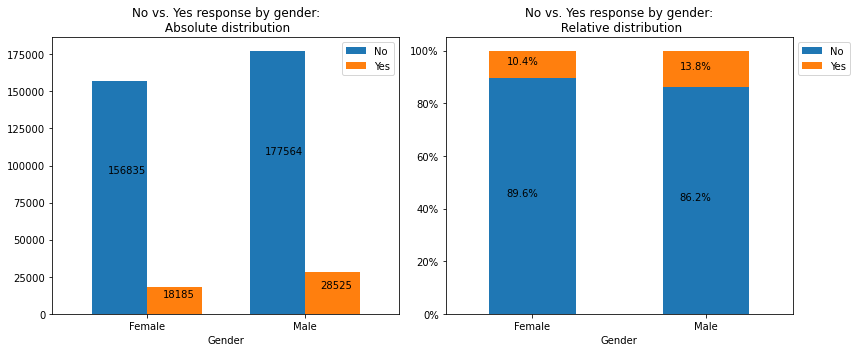

In [19]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['Gender', 'Response'])['Response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('No vs. Yes response by gender:\n Absolute distribution') 
plt.legend(['No', 'Yes'])
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['Gender','Response'])['Response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['No', 'Yes'], bbox_to_anchor=(1, 1))
plt.title('No vs. Yes response by gender:\n Relative distribution') 


#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))


    
plt.tight_layout()
plt.show()

##### Observation

We found that Male are more likely to response to our car insurance. 

#### 3.4.1.2. Driving_License and Response

##### Objective

We decided to explore how the distribution of "Driving_License" will differ from the Non-response cases and the Response cases. 

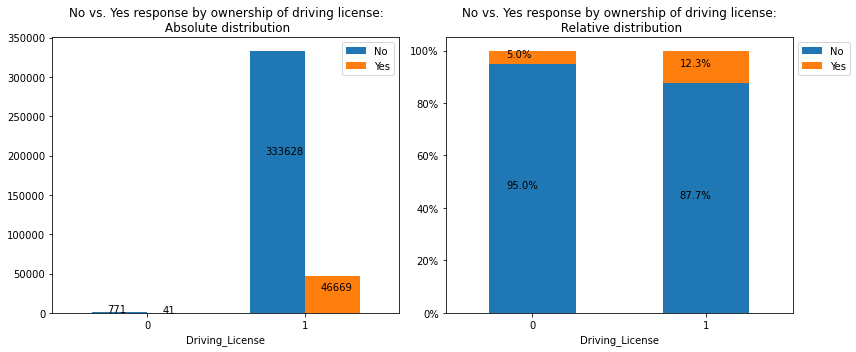

In [20]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['Driving_License', 'Response'])['Response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('No vs. Yes response by ownership of driving license:\n Absolute distribution') 
plt.legend(['No', 'Yes'])

#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['Driving_License','Response'])['Response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['No', 'Yes'],bbox_to_anchor=(1, 1))
plt.title('No vs. Yes response by ownership of driving license:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

##### Observation

We found that people who have a driving license would be more likely to response to our care insurance.

However, for this feature, the data distribution is extremely imbalanced, almost no person in our investigation scale has no driving license. Therefore, we decided to drop this column in the future. 

#### 3.4.1.3. Previously_Insured and Response

##### Objective

We decided to explore how the distribution of "Previously_Insured" will differ from the Non-response cases and the Response cases. 

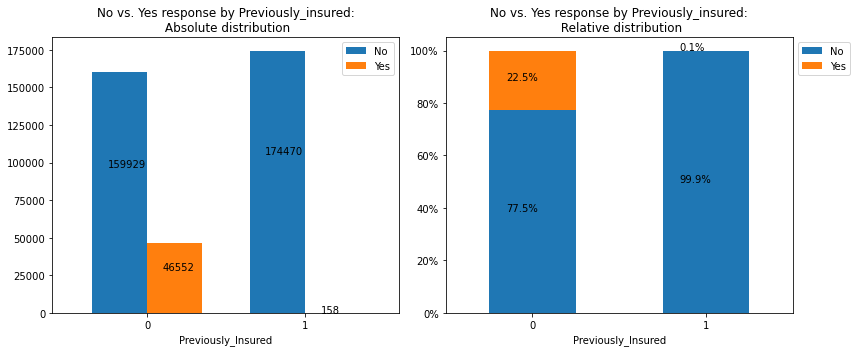

In [22]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['Previously_Insured', 'Response'])['Response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('No vs. Yes response by Previously_insured:\n Absolute distribution') 
plt.legend(['No', 'Yes'])
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['Previously_Insured','Response'])['Response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['No', 'Yes'], bbox_to_anchor=(1, 1))
plt.title('No vs. Yes response by Previously_insured:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

##### Observation

We found that customers who are not previously insured by a car insurance issued by other companies are much more likely to response to our car insurance. 

#### 3.4.1.4. Vehicle_Age and Response

##### Objective

We decided to explore how the distribution of "Vehicle_Age" will differ from the Non-response cases and the Response cases. 

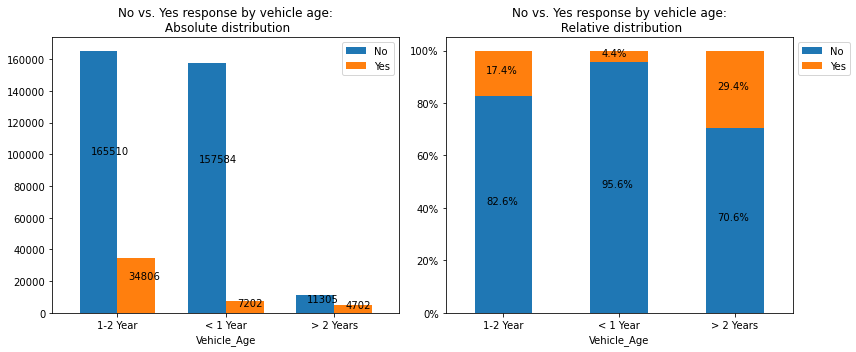

In [23]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['Vehicle_Age', 'Response'])['Response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('No vs. Yes response by vehicle age:\n Absolute distribution') 
plt.legend(['No', 'Yes'])
#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['Vehicle_Age','Response'])['Response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['No', 'Yes'],bbox_to_anchor=(1, 1))
plt.title('No vs. Yes response by vehicle age:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:3], ax2.patches[3:6]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

##### Observation

We found that The older a vehicle is, the more likely its owner is to response.


#### 3.4.1.5. Vehicle_Damage and Response

##### Objective

We decided to explore how the distribution of "Vehicle_Damage" will differ from the Non-response cases and the Response cases. 

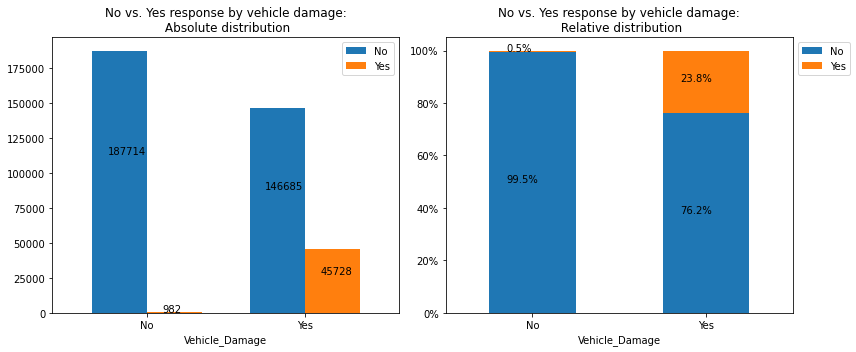

In [24]:
fig = plt.figure(figsize=(12, 5)) #specify figure size

#Absolute distribution
plt.subplot(1, 2, 1)
ax1 = data.groupby(['Vehicle_Damage', 'Response'])['Response'].count().unstack().plot.bar(rot=0, ax=plt.gca(), width=0.7)
plt.title('No vs. Yes response by vehicle damage:\n Absolute distribution') 
plt.legend(['No', 'Yes'])

#plot bar labels
for p in ax1.patches:
    ax1.annotate(str(p.get_height()), (p.get_x() +0.1, p.get_height() * 0.605))

#Relative distribution
plt.subplot(1, 2, 2)
ax2 = data.groupby(['Vehicle_Damage','Response'])['Response'].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()).unstack().plot(kind='bar',stacked=True, rot=0, ax=plt.gca())
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['No', 'Yes'], bbox_to_anchor=(1, 1))
plt.title('No vs. Yes response by vehicle damage:\n Relative distribution') 
#plot bar labels
for p, q in zip(ax2.patches[0:2], ax2.patches[2:4]):
    ax2.annotate(str(round(p.get_height(),1)) + '%', (p.get_x()+0.1, p.get_height()/2))
    ax2.annotate(str(round(q.get_height(),1)) + '%', (q.get_x()+0.1, q.get_height()/2+p.get_height()))

plt.tight_layout()
plt.show()

##### Observation

We found that customers who have expreinced car damages are more likely to response to our car insurance. And the difference is significant. 

### 3.4.2. Numerical features

#### Objective

We are trying to explore the data distribution of numerical columns, including observing the number of unique values in each columns, and then determing whether we should drop some irrelevant/meaningless columns. 

#### 3.4.2.1. Region_code and Policiy_Sales_Channel

In [34]:
print('Number of unique values/ levels in the Region_Code feature: '+ str(data['Region_Code'].nunique()))
print('Number of unique values/ levels in the Policiy feature: '+ str(data['Policy_Sales_Channel'].nunique()))

Number of unique values/ levels in the Region_Code feature: 53
Number of unique values/ levels in the Policiy feature: 155


##### Observation

These two features are identifier; hence, their observations could not be intepreted as numeric value. In later stage, if using one hot encoding, it will add 208 new columns to dataset. Our group also considered some solutions (e.g divide 'Region_code' values into groups like 'northern' or 'southern'). However, due to limited background information about the company and these features, dropping them is the optimal choice.

#### 3.4.2.2. Age and Response

##### Objective

We decided to explore how the distribution of "Age" will differ from the Non-response cases and the Response cases. 

/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


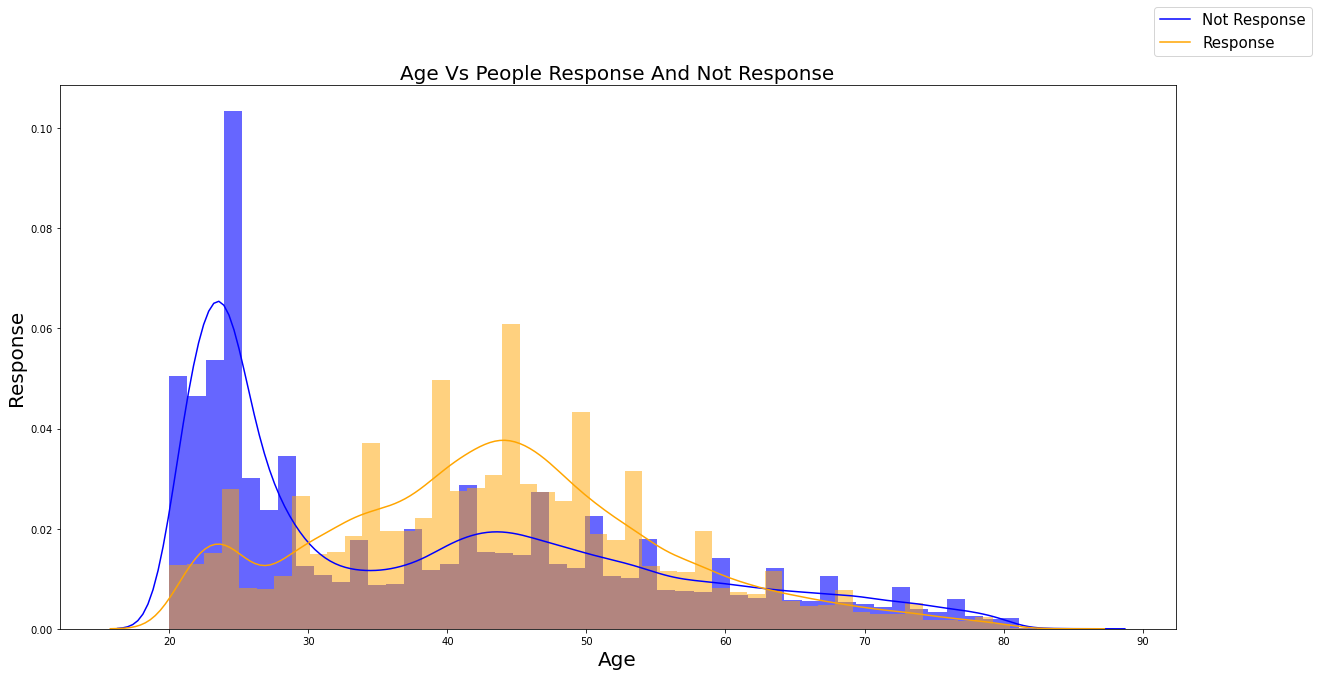

In [35]:
fig=plt.figure(figsize=(20,10))
sns.distplot(data[data['Response']==0]['Age'],color='blue',hist_kws={'alpha':0.6})
sns.distplot(data[data['Response']==1]['Age'],color='orange',hist_kws={'alpha':0.5})
fig.legend(labels=['Not Response','Response'],fontsize=15)
plt.xlabel('Age',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Age Vs People Response And Not Response',fontsize=20)
plt.show()

##### Observation

We found that customers whose ages are between 30 and 60 are more likely to response to our car insurance that customers whose ages are between 20 and 30. 

#### 3.4.2.2. Annual_Premium and Response

##### Objective

We decided to explore how the distribution of "Annual_Premium" will differ from the Non-response cases and the Response cases. 

/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Annual_Premium Vs People Response And Not Response')

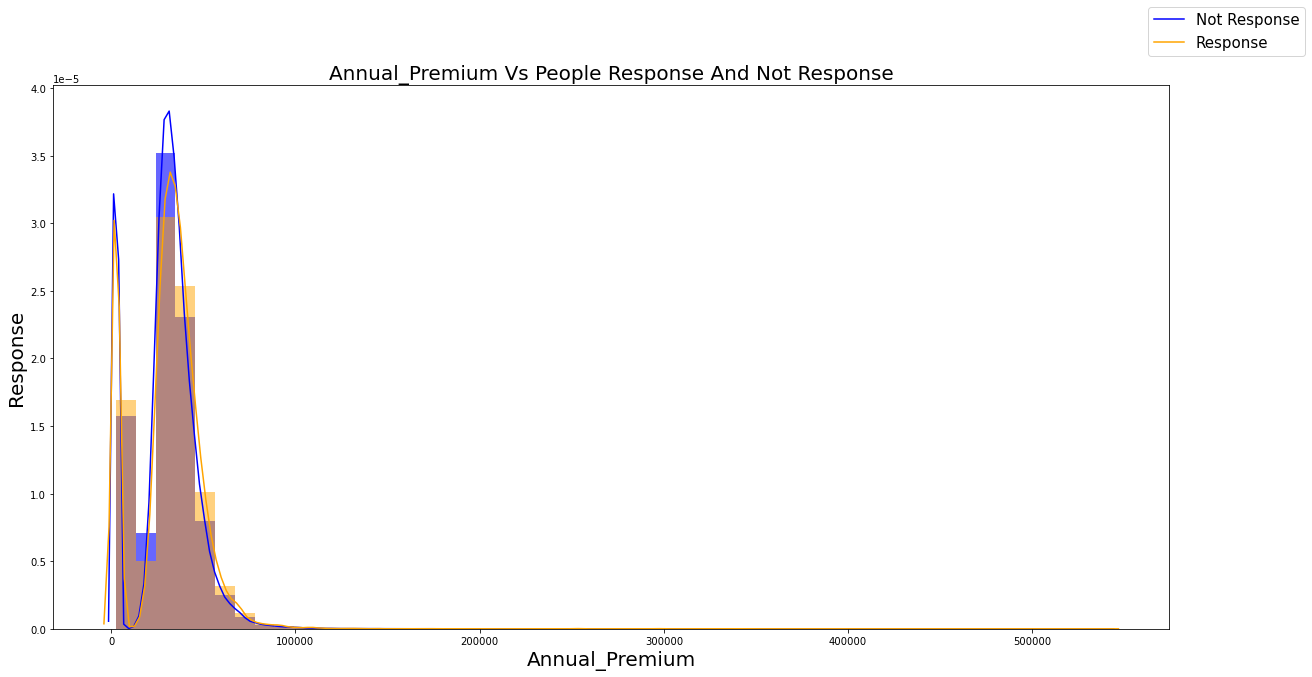

In [36]:
fig=plt.figure(figsize=(20,10))
sns.distplot(data[data['Response']==0]['Annual_Premium'],color='blue',hist_kws={'alpha':0.6})
sns.distplot(data[data['Response']==1]['Annual_Premium'],color='orange',hist_kws={'alpha':0.5})
fig.legend(labels=['Not Response','Response'],fontsize=15)
plt.xlabel('Annual_Premium',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Annual_Premium Vs People Response And Not Response',fontsize=20)

##### Observation

Annual_Premium has a long-tailed distribution, with a lot of observations on the low value end, and few on the high value end. We did not find clear clues to explain the distribution of Annual_Premium.

#### 3.4.2.2. Vintage and Response

##### Objective

We decided to explore how the distribution of "Vintage" will differ from the Non-response cases and the Response cases. 

/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/software/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Vintage Vs People Response And Not Response')

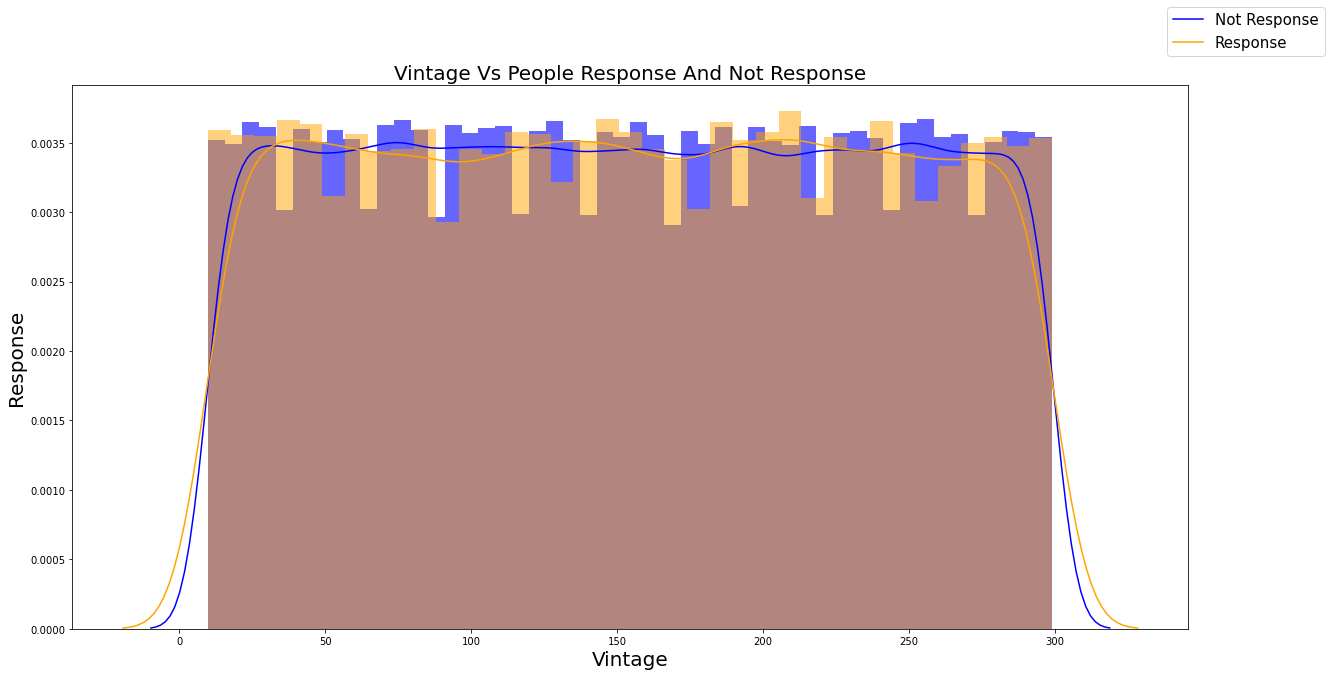

In [39]:
fig=plt.figure(figsize=(20,10))
sns.distplot(data[data['Response']==0]['Vintage'],color='blue',hist_kws={'alpha':0.6})
sns.distplot(data[data['Response']==1]['Vintage'],color='orange',hist_kws={'alpha':0.5})
fig.legend(labels=['Not Response','Response'],fontsize=15)
plt.xlabel('Vintage',fontsize=20)
plt.ylabel('Response',fontsize=20)
plt.title('Vintage Vs People Response And Not Response',fontsize=20)

##### Observation

We did not find clear clues to explain the distribution of Vintage. 

<a id='preprocessing'></a>
## 4. Data Pre-processing

## 4.1. Drop data

As the reasons described in the EDA part, We decided to drop these columns: 'id','Driving_License','Region_Code', and "Policy_Sales_Channel". 

These columns provided little information and include meaningless numbers in the real world. We cannot take them into consideration for conducting the predictive models until we have enough additional information to explain them. 

In [40]:
data = data.drop(['id','Driving_License','Region_Code',"Policy_Sales_Channel"], axis=1)

## 4.2. Encode categorical variables

In [41]:
data = pd.get_dummies(data, columns=["Gender", "Vehicle_Age","Vehicle_Damage"], prefix=["Gender", "Vehicle_Age","Vehicle_Damage"], drop_first=True)
data.head()

,Age,Previously_Insured,Annual_Premium,Vintage,Response,Gender_Male,Vehicle_Age_< 1 Year,Vehicle_Age_> 2 Years,Vehicle_Damage_Yes
0,44,0,40454.0,217,1,1,0,1,1
1,76,0,33536.0,183,0,1,0,0,0
2,47,0,38294.0,27,1,1,0,1,1
3,21,1,28619.0,203,0,1,1,0,0
4,29,1,27496.0,39,0,0,1,0,0


## 4.3. Data Split

The original data set was already split to 'train' and 'test', but as the 'test' data set was missing value, we decided to split the 'train' data again into 'train_new' and 'test_new'

In [42]:
X, y = data.loc[:, data.columns != 'Response'], data['Response']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 12345)

#### Visualization of the split data

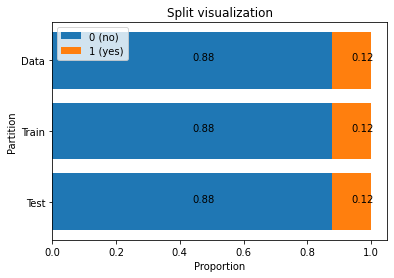

In [43]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)

fig, ax = plt.subplots()

ax.barh(['Test','Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Test','Train','Data'], [test_dist[1], train_dist[1], data_dist[1]], left=[test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Test', 'Train','Data'], [test_dist[0], train_dist[0], data_dist[0]], [test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

## 4.4. Data Balancing

Data rebalancing with SMOTE

In [44]:
smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_resample(X_train, y_train)

In [45]:
def plot_2d_space(X, y, label='Classes', title='x', xlabel='x', ylabel='y'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m, s=2
        )
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='upper right')

Original label Counter({0: 234078, 1: 32698})
SMOTE label Counter({0: 234078, 1: 234078})


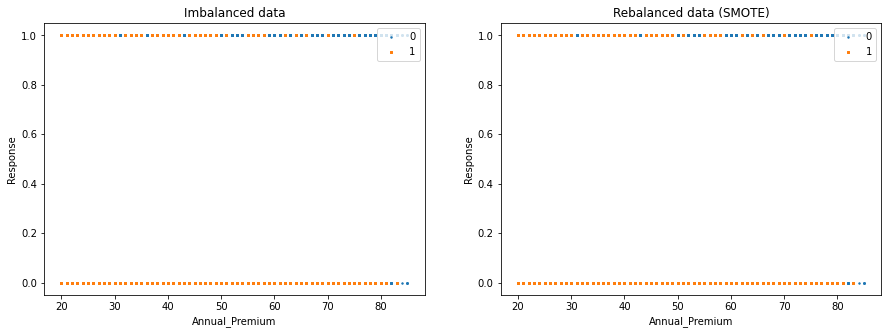

In [46]:
print('Original label %s' % Counter(y_train))
print('SMOTE label %s' % Counter(y_sm))

fig = plt.figure(figsize=(15, 5))

ax0 = plt.subplot(121)
ax0 = plot_2d_space(np.array(X_train), y_train, title='Imbalanced data', xlabel='Annual_Premium', ylabel='Response')

ax1 = plt.subplot(122)
ax1 = plot_2d_space(np.array(X_sm), y_sm, title='Rebalanced data (SMOTE)', xlabel='Annual_Premium', ylabel='Response')

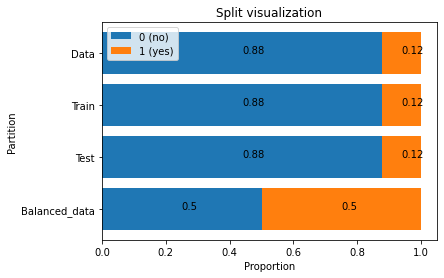

In [47]:
train_dist = y_train.value_counts() / len(y_train) #normalize absolute count values for plotting
test_dist = y_test.value_counts() / len(y_test)
data_dist = y.value_counts() / len(y)
smote_dist = pd.Series(y_sm).value_counts() / len(pd.Series(y_sm))

fig, ax = plt.subplots()

ax.barh(['Balanced_data','Test','Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#1f77b4', label='0 (no)')
ax.barh(['Balanced_data','Test','Train','Data'], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]], left=[smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], color='#ff7f0e', label='1 (yes)')
ax.set_title('Split visualization')
ax.legend(loc='upper left')
plt.xlabel('Proportion')
plt.ylabel('Partition')

#plot bar values
for part, a, b in zip(['Balanced_data', 'Test', 'Train','Data'], [smote_dist[0], test_dist[0], train_dist[0], data_dist[0]], [smote_dist[1], test_dist[1], train_dist[1], data_dist[1]]):
    plt.text(a/2, part, str(np.round(a, 2)))
    plt.text(b/2+a, part, str(np.round(b, 2)));

<a id='predictive'></a>
## 5. Predictive Model Building

## 5.1 Decision Tree Model

### 5.1.1. Imbalanced dataset

In [49]:
tree_imb = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_train, y_train)

In [50]:
y_pred_tree_imb = tree_imb.predict(X_test)
y_predProba_tree_imb = tree_imb.predict_proba(X_test)
print ("DT accuracy of imbalanced data is: ", (accuracy_score(y_test, y_pred_tree_imb)*100).round(2))

DT accuracy of imbalanced data is:  87.74


#### 5.1.1.1 .Tree visualization

Fontconfig error: Cannot load default config file



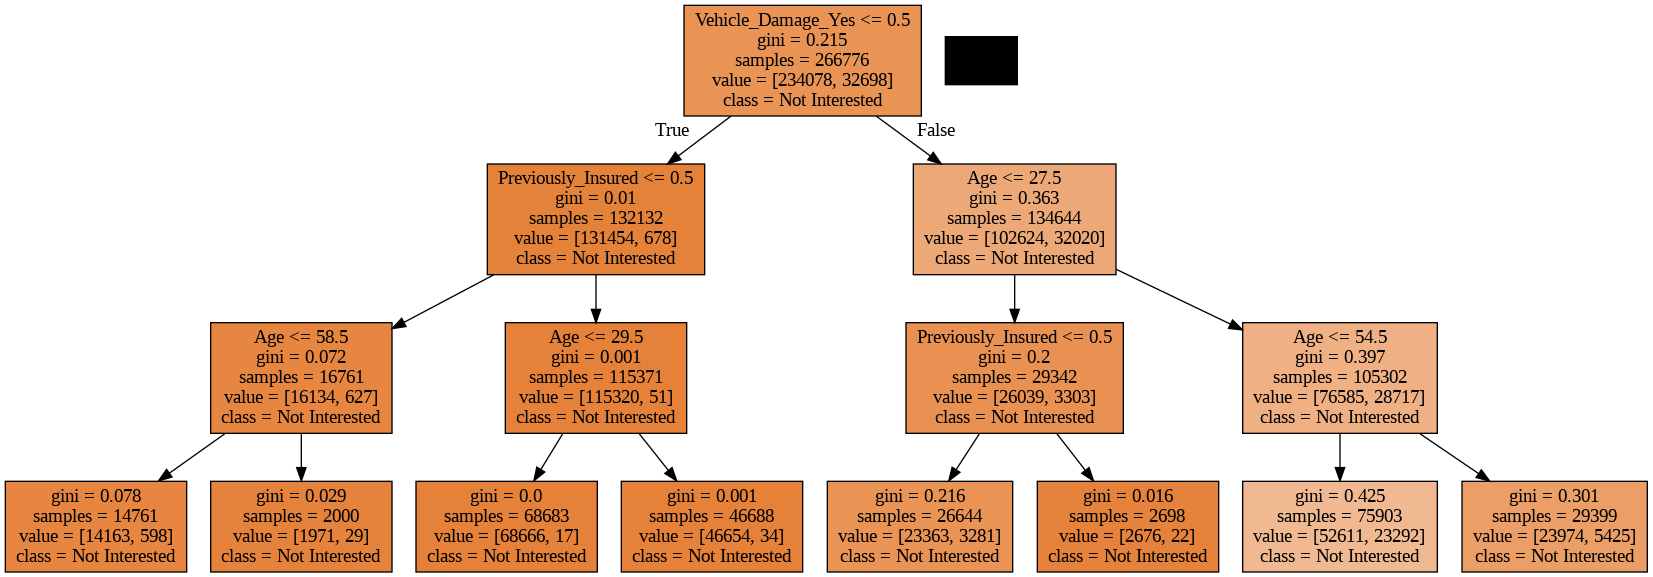

In [51]:
'''
The graphviz library is used to visualize the tree. 
'''

#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(tree_imb, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not Interested', 'Interested'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#### 5.1.1.2. Plot the feature importances of the tree

In [52]:
importances = tree_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

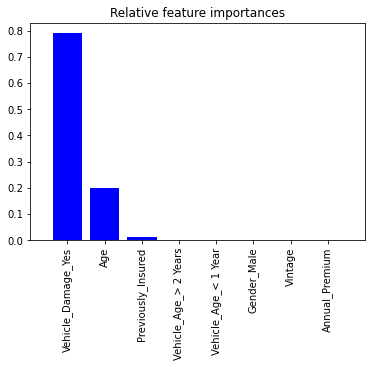

In [53]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 5.1.2. Balanced dataset

In [54]:
tree_bal = tree.DecisionTreeClassifier(criterion = "gini", random_state = 100,
                               max_depth=3, min_samples_leaf=3).fit(X_sm, y_sm)

y_pred_tree_bal = tree_bal.predict(X_test)
y_predProba_tree_bal = tree_bal.predict_proba(X_test)
print ("DT accuracy of balanced data is: ", (accuracy_score(y_test, y_pred_tree_bal)*100).round(2))

DT accuracy of balanced data is:  74.11


#### 5.1.2.1. Tree visualization

Fontconfig error: Cannot load default config file



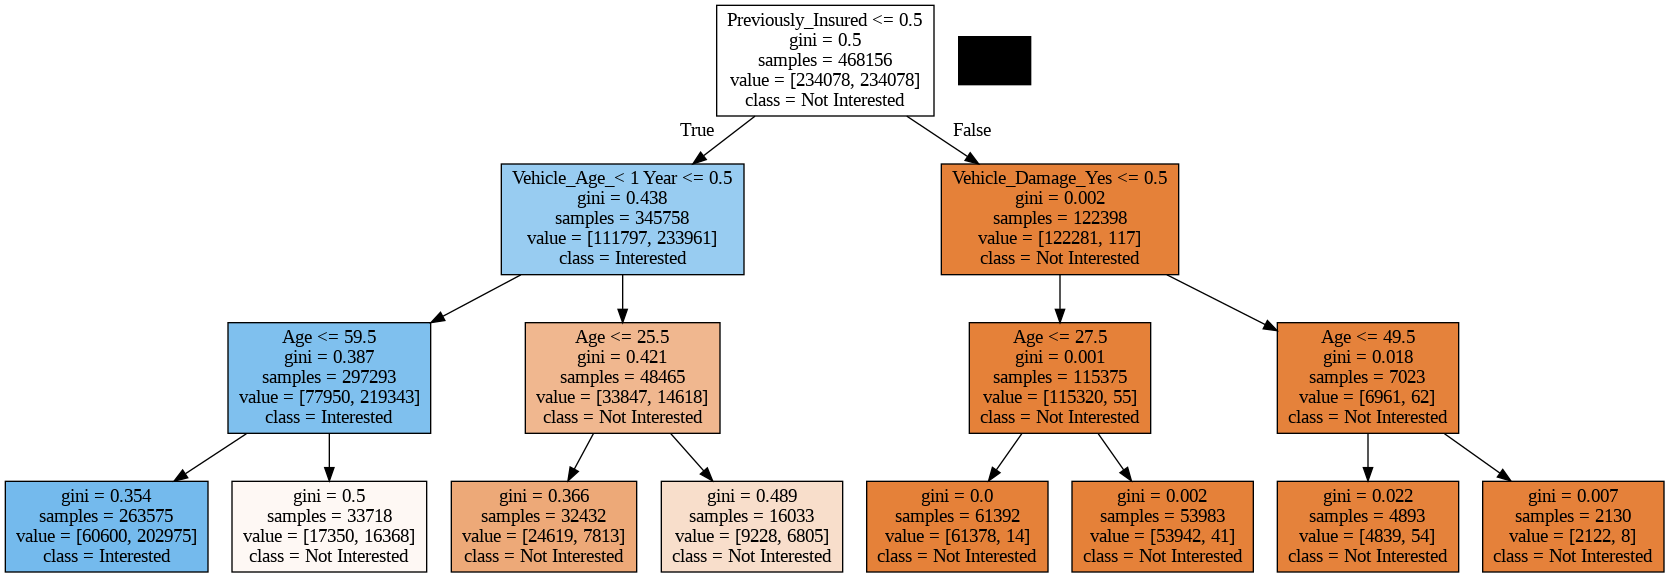

In [55]:
'''
The graphviz library is used to visualize the tree. 
'''

#Decision tree plot
import pydotplus
from IPython.display import Image 

# Create DOT data
dot_data = tree.export_graphviz(tree_bal, out_file=None, 
                                feature_names=X_train.columns, 
                                class_names=['Not Interested', 'Interested'], filled=True) #or use y_train.unique()

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

#### 5.1.2.2. Plot the feature importances of the tree

In [56]:
importances = tree_bal.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

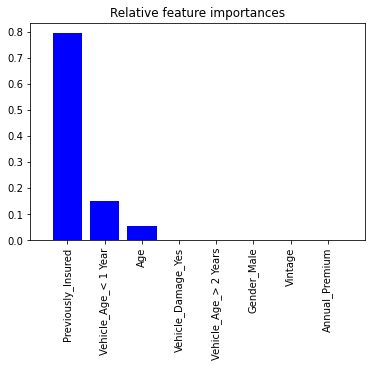

In [57]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 5.1.3. Model Comparison

#### 5.1.3.1. Confusion Matrix

In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylim([1.5, -0.5]) #added to fix a bug that causes the matrix to be squished
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

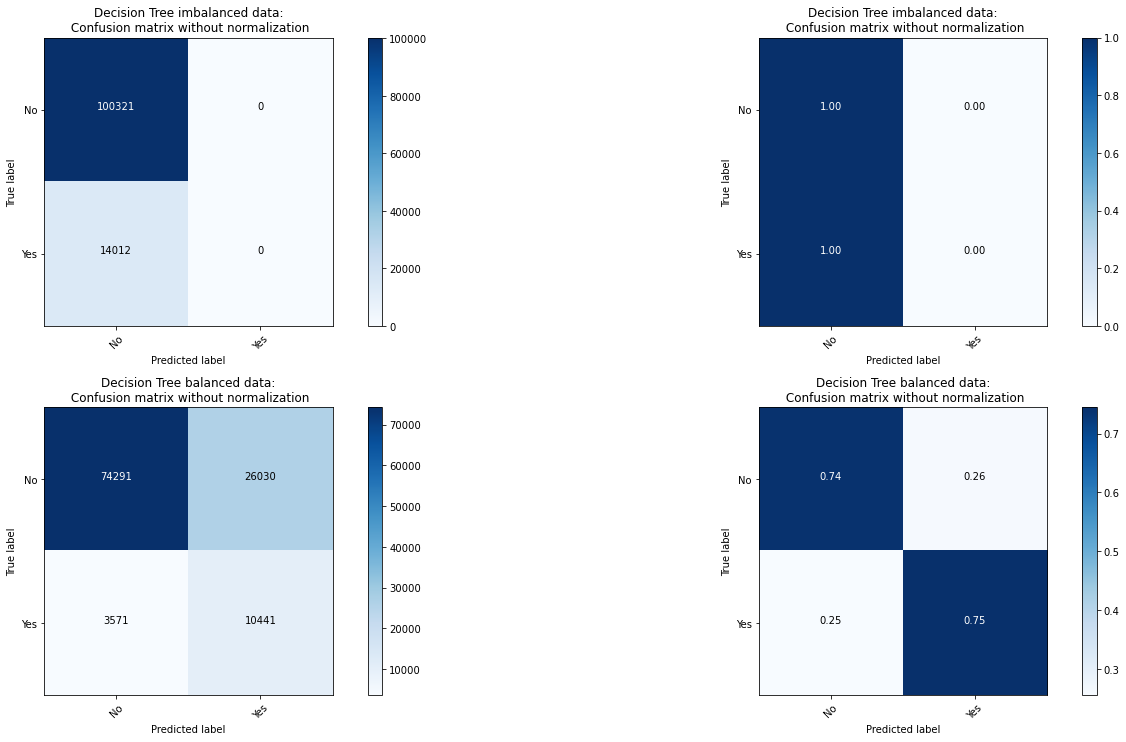

In [59]:
class_names = ['No','Yes']
cnf_matrix_tree_imb = confusion_matrix(y_test, y_pred_tree_imb)
cnf_matrix_tree_bal = confusion_matrix(y_test, y_pred_tree_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Decision Tree (imbalanced) confusion matrix
plt.subplot(321)
plot_confusion_matrix(cnf_matrix_tree_imb, classes=class_names,
                      title='Decision Tree imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (imbalanced) normalized confusion matrix
plt.subplot(322)
plot_confusion_matrix(cnf_matrix_tree_imb, classes=class_names,normalize=True,
                      title='Decision Tree imbalanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_tree_bal, classes=class_names,
                      title='Decision Tree balanced data:\n Confusion matrix without normalization')

#Plot Decision Tree (balanced) normalized confusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_tree_bal, classes=class_names,normalize=True,
                      title='Decision Tree balanced data:\n Confusion matrix without normalization')

plt.show()

#### 5.1.3.2. ROC & AUC

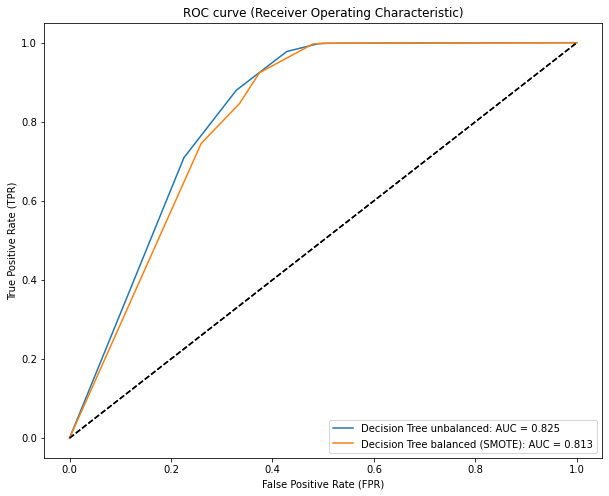

In [60]:
plt.figure(figsize=(10,8))

for test, pred, name in zip([y_test, y_test], [y_predProba_tree_imb[:,1], y_predProba_tree_bal[:,1]], ['Decision Tree unbalanced','Decision Tree balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## 5.2. Logistics Regression

### 5.2.1. Imbalanced data

In [61]:
lr_ibal = LogisticRegression().fit(X_train, y_train)

In [62]:
y_pred_lr_ibal = lr_ibal.predict(X_test)
y_predProba_lr_ibal = lr_ibal.predict_proba(X_test)
print ("LR accuracy of imbalanced data is: ", (accuracy_score(y_test, y_pred_lr_ibal)*100).round(2))

LR accuracy of imbalanced data is:  87.55


### 5.2.2. Balanced data

In [63]:
lr_bal = LogisticRegression().fit(X_sm, y_sm)

In [64]:
y_pred_lr_bal = lr_bal.predict(X_test)
y_predProba_lr_bal = lr_bal.predict_proba(X_test)
print ("LR accuracy of imbalanced data is:", (accuracy_score(y_test, y_pred_lr_bal)*100).round(2))

LR accuracy of imbalanced data is: 46.98


### 5.2.3. Model Comparison

#### 5.2.3.1. Confusion Matrix

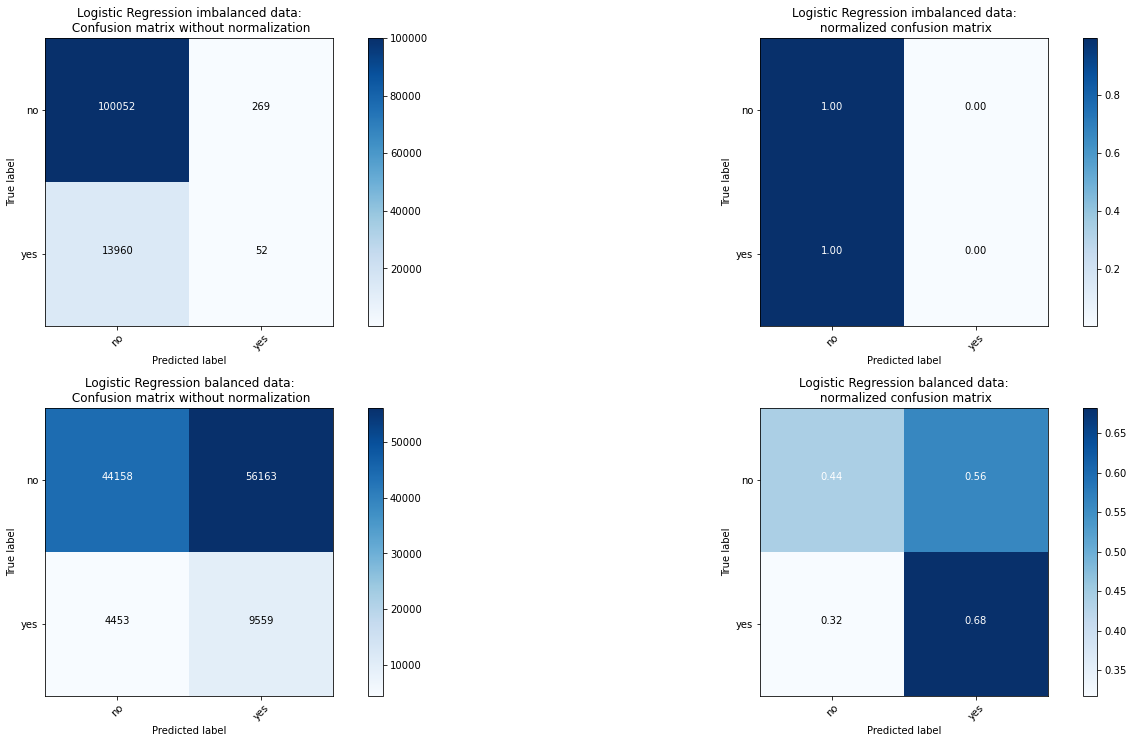

In [66]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_lr_ibal = confusion_matrix(y_test, y_pred_lr_ibal)
cnf_matrix_lr_bal = confusion_matrix(y_test, y_pred_lr_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot Logistic Regression (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_lr_ibal, classes=class_names,
                      title='Logistic Regression imbalanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (imbalanced) normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_lr_ibal, classes=class_names, normalize=True,
                      title='Logistic Regression imbalanced data:\n normalized confusion matrix')


#Plot Logistic Regression (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names,
                      title='Logistic Regression balanced data:\n Confusion matrix without normalization')

#Plot Logistic Regression (balanced) normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_lr_bal, classes=class_names, normalize=True,
                      title='Logistic Regression balanced data:\n normalized confusion matrix')



#### 5.2.3.2. AUC and ROC

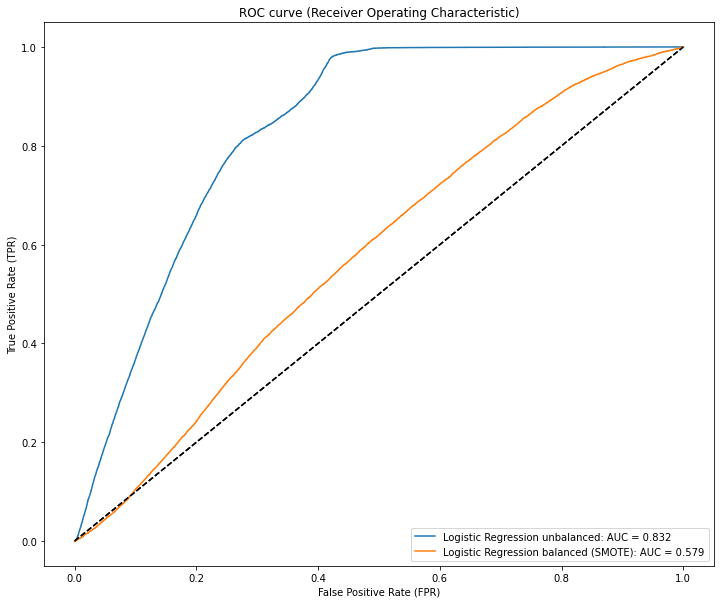

In [67]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test], [y_predProba_lr_ibal[:,1], y_predProba_lr_bal[:,1]], ['Logistic Regression unbalanced','Logistic Regression balanced (SMOTE)']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## 5.3. Random Forest

### 5.3.1. Imbalance data

In [68]:
from sklearn.ensemble import RandomForestClassifier
rf_imb = RandomForestClassifier(max_depth = 3, min_samples_leaf=10,random_state=42, n_estimators=10, n_jobs=-1).fit(X_train,y_train)

In [69]:
y_pred_rf_imb = rf_imb.predict(X_test)
y_predProba_rf_imb = rf_imb.predict_proba(X_test)
print ("RF accuracy of imbalanced data is: ", (accuracy_score(y_test, y_pred_rf_imb)*100).round(2))

RF accuracy of imbalanced data is:  87.74


#### 5.3.1.1. Plot the feature importances of the random forest

In [73]:
importances = rf_imb.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

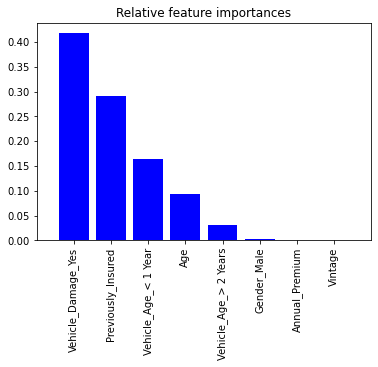

In [74]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 5.3.2. Balanced data

In [76]:
rf_bal = RandomForestClassifier(max_depth = 3, min_samples_leaf=10,random_state=42, n_estimators=10, n_jobs=-1).fit(X_sm,y_sm)

In [77]:
y_pred_rf_bal = rf_bal.predict(X_test)
y_predProba_rf_bal = rf_bal.predict_proba(X_test)
print ("Accuracy is: ", (accuracy_score(y_test, y_pred_rf_bal)*100).round(2))

Accuracy is:  70.5


#### 5.3.2.1. Plot the feature importances of the random forest

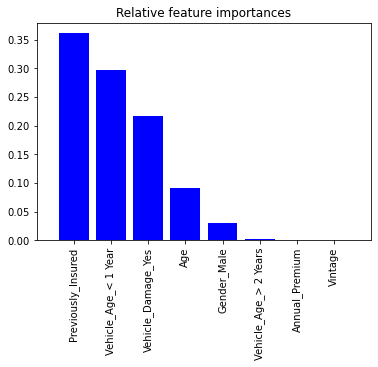

In [78]:
importances = rf_bal.feature_importances_
indices = np.argsort(importances)[::-1]
feature_order = np.array([X.columns.values])
i = np.argsort(importances)[::-1]
feature_order = feature_order[:,i]

# Plot the feature importances of the forest
plt.figure()
plt.title("Relative feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b",  align="center")
plt.xticks(range(X.shape[1]), feature_order[0], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.show()

### 5.3.3. Model Comparison

#### 5.3.3.1. Confusion Matrix

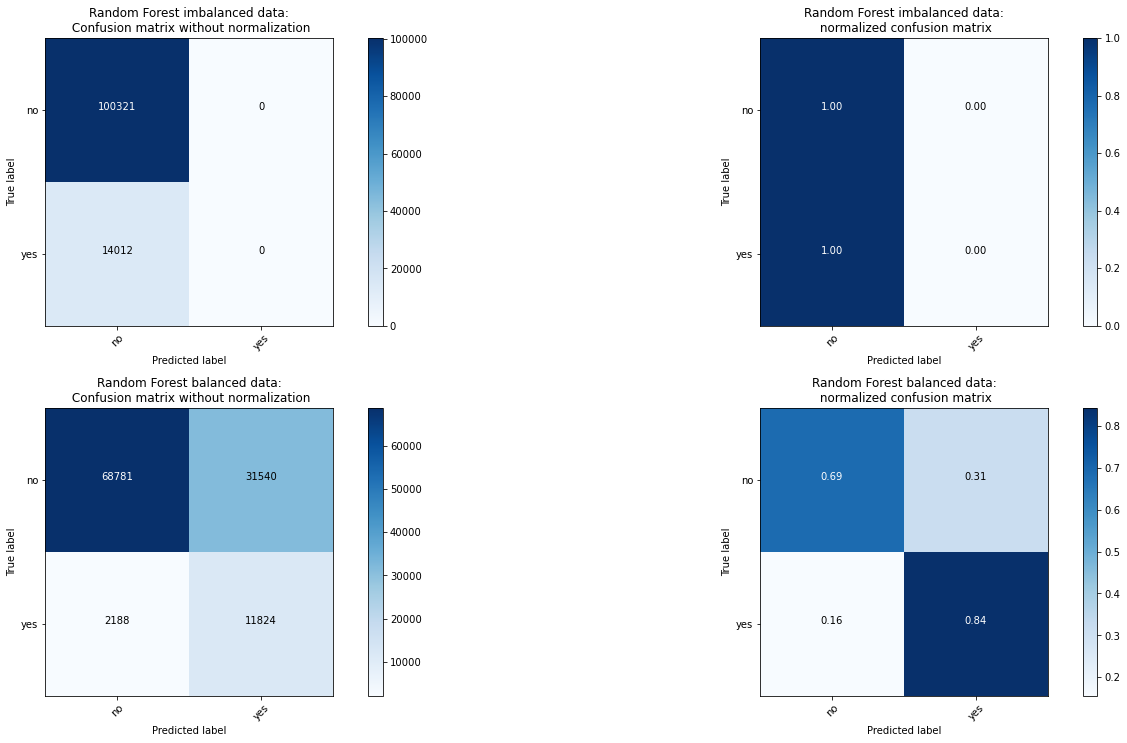

In [79]:
# Compute confusion matrix
class_names = ['no', 'yes']
cnf_matrix_rf_imb = confusion_matrix(y_test, y_pred_rf_imb)
cnf_matrix_rf_bal = confusion_matrix(y_test, y_pred_rf_bal)

np.set_printoptions(precision=2)

plt.figure(figsize=(20, 15))

#Plot K-Nearest Neighbors (imbalanced) confusion matrix
plt.subplot(321) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names,
                      title='Random Forest imbalanced data:\n Confusion matrix without normalization')

#Plot K-Nearest Neighbors (imbalanced) normalized confusion matrix
plt.subplot(322) 
plot_confusion_matrix(cnf_matrix_rf_imb, classes=class_names, normalize=True,
                      title='Random Forest imbalanced data:\n normalized confusion matrix')

#Plot K-Nearest Neighbors (balanced) confusion matrix
plt.subplot(323) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names,
                      title='Random Forest balanced data:\n Confusion matrix without normalization')

#Plot K-Nearest Neighbors (balanced) normalized onfusion matrix
plt.subplot(324) 
plot_confusion_matrix(cnf_matrix_rf_bal, classes=class_names, normalize=True,
                      title='Random Forest balanced data:\n normalized confusion matrix')

#### 5.3.3.2. AUC and ROC

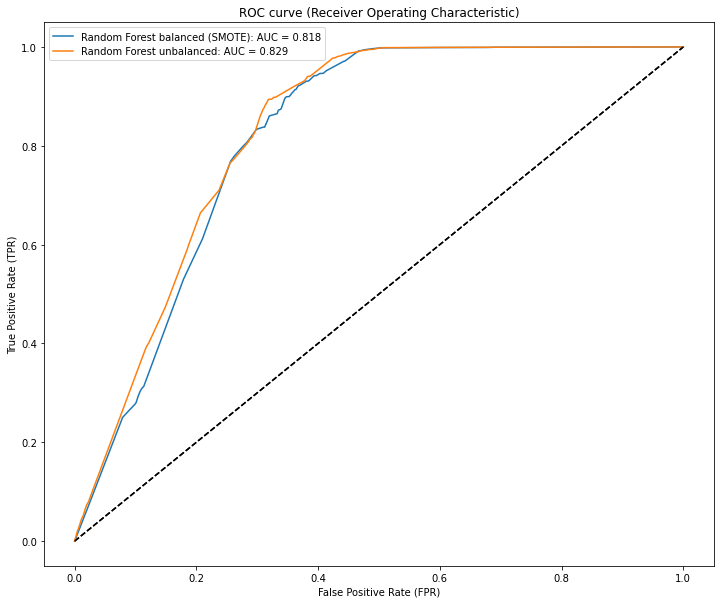

In [80]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test], [y_predProba_rf_bal[:,1], y_predProba_rf_imb[:,1]], ['Random Forest balanced (SMOTE)', 'Random Forest unbalanced']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

<a id='featureselection'></a>
## 6. Feature selection 

After seeing the result of feature importance shown by all three models, we found that "Annual_Premium" and "Vintage" are two less significant features for the predictive models.


## Test Logistics Regression when dropping 'Annual Premium' and ' Vintage'

In [81]:
X_sm_new=X_sm.drop(['Annual_Premium','Vintage'],axis=1)

In [82]:
X_test_new=X_test.drop(['Annual_Premium','Vintage'],axis=1)

In [83]:
lr_bal2 = LogisticRegression().fit(X_sm_new, y_sm)

In [84]:
y_pred_lr_bal2 = lr_bal2.predict(X_test_new)
y_predProba_lr_bal2 = lr_bal2.predict_proba(X_test_new)
print ("LR accuracy of new data is:", (accuracy_score(y_test, y_pred_lr_bal2)*100).round(2))

LR accuracy of new data is: 73.34


<a id='evaluation'></a>
## 7. Model evaluation

### 7.1 Accuracy score

In [85]:
model = ['Decision Tree', 'Logistics Regression (Feature Selection)', 'Logistics Regression', 'Random Forest']

score = [(accuracy_score(y_test, y_pred_tree_bal)*100).round(2),(accuracy_score(y_test, y_pred_lr_bal2)*100).round(2),(accuracy_score(y_test, y_pred_lr_bal)*100).round(2),(accuracy_score(y_test, y_pred_rf_bal)*100).round(2)]  


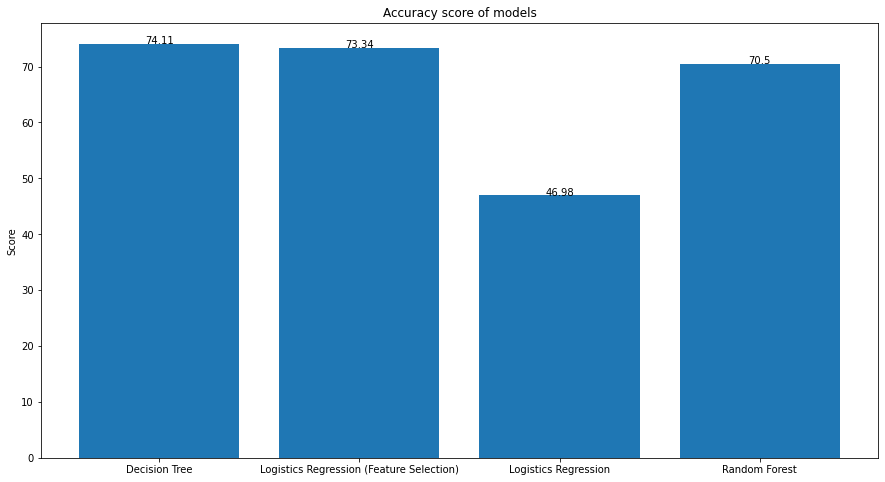

In [91]:
plt.figure(figsize=(15,8)) 
plt.bar(model,score)
plt.title("Accuracy score of models")
plt.ylabel("Score")

for index, value in enumerate(score):
    plt.text(index,value, str(value), ha='center')
plt.show()
    
plt.show()

## 7.2 ROC and AUC

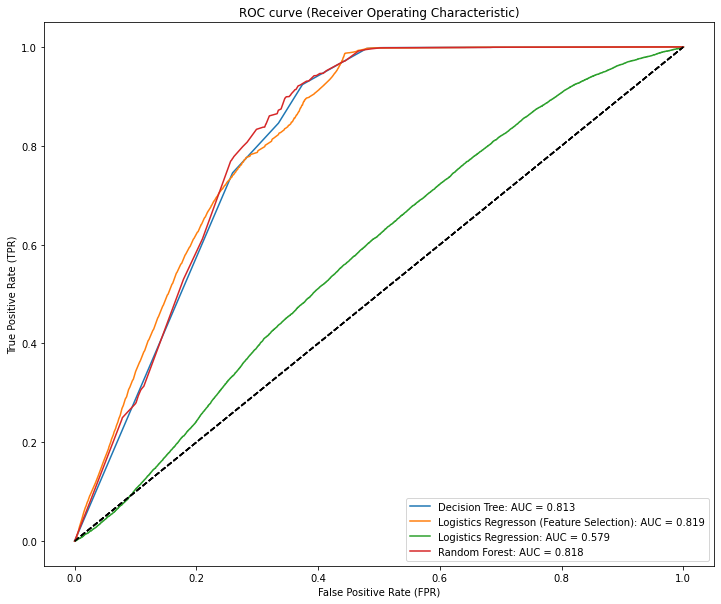

In [92]:
plt.figure(figsize=(12,10))

for test, pred, name in zip([y_test, y_test, y_test, y_test], [y_predProba_tree_bal[:,1], y_predProba_lr_bal2[:,1] , y_predProba_lr_bal[:,1], y_predProba_rf_bal[:,1]], ['Decision Tree','Logistics Regresson (Feature Selection)', 'Logistics Regression', 'Random Forest']):
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{}: AUC = {}'.format(name, round(roc_auc, 3)))
    plt.legend(loc='best')
    plt.plot([0,1],[0,1],color='black', linestyle='--')

plt.title('ROC curve (Receiver Operating Characteristic)')    
plt.ylabel('True Positive Rate (TPR)')
plt.xlabel('False Positive Rate (FPR)')

plt.show()

## 7.3 Cost-Benefit Analysis

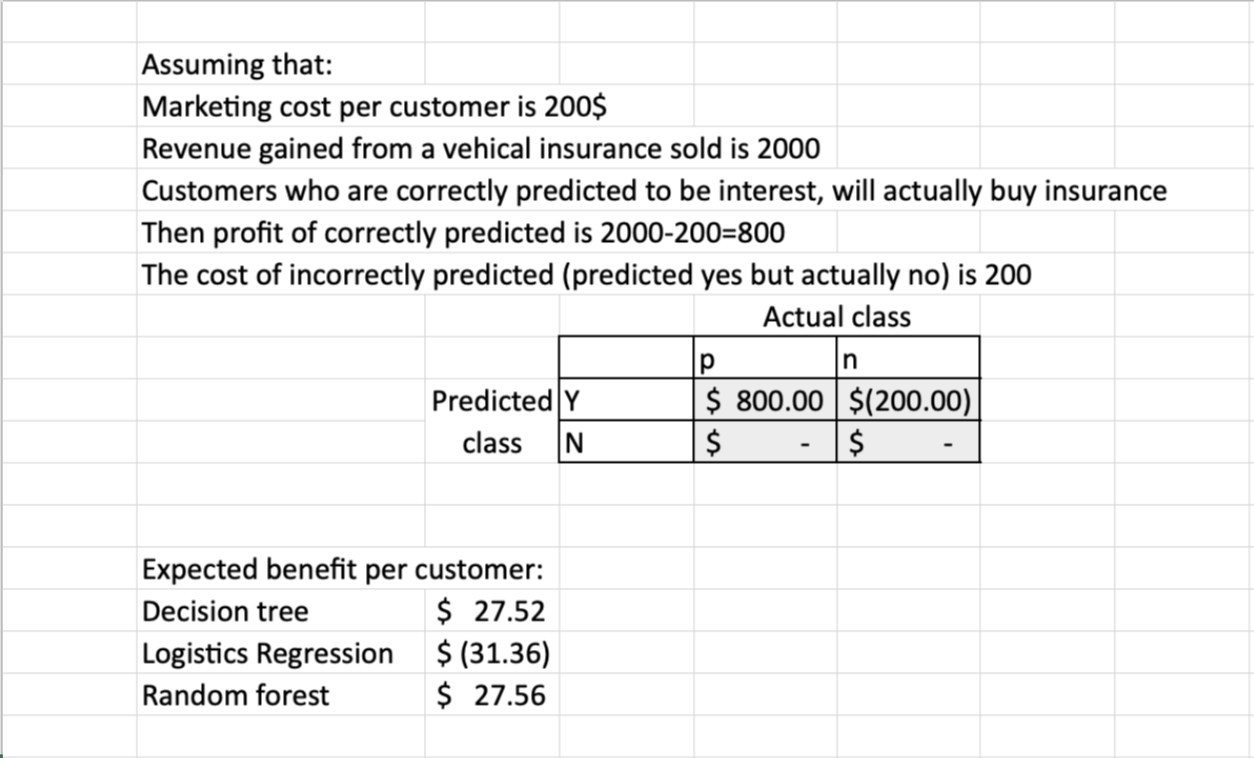

### 7.3.1 Cost-Benefit Analysis for Decision Tree 

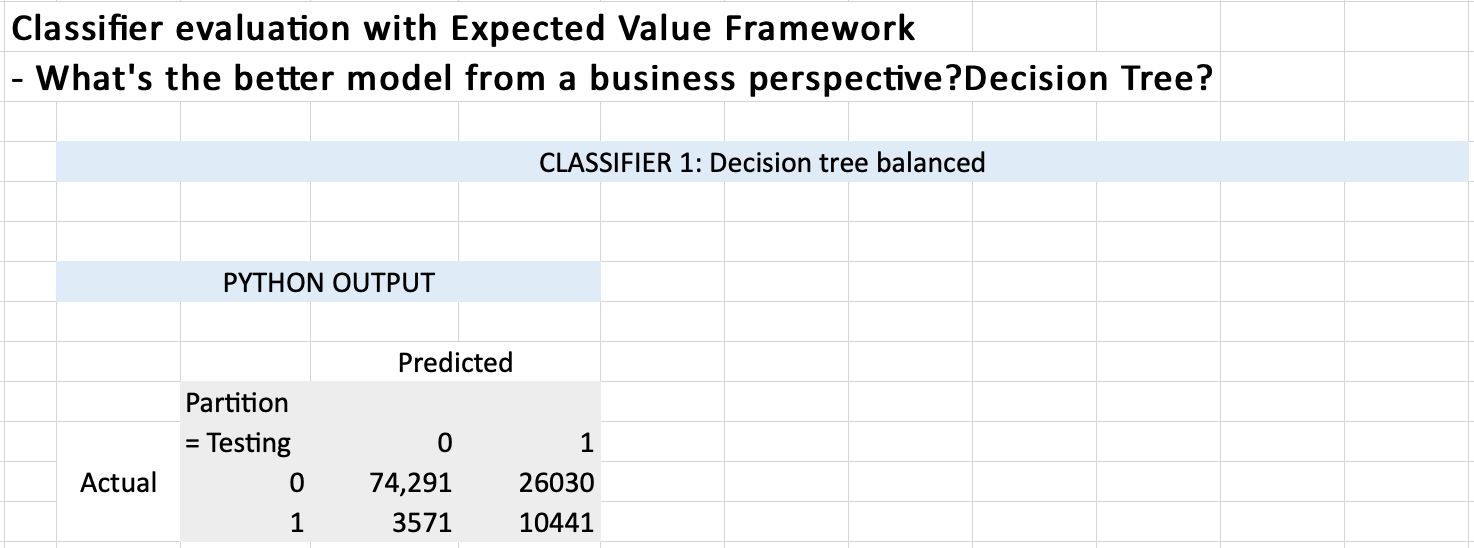

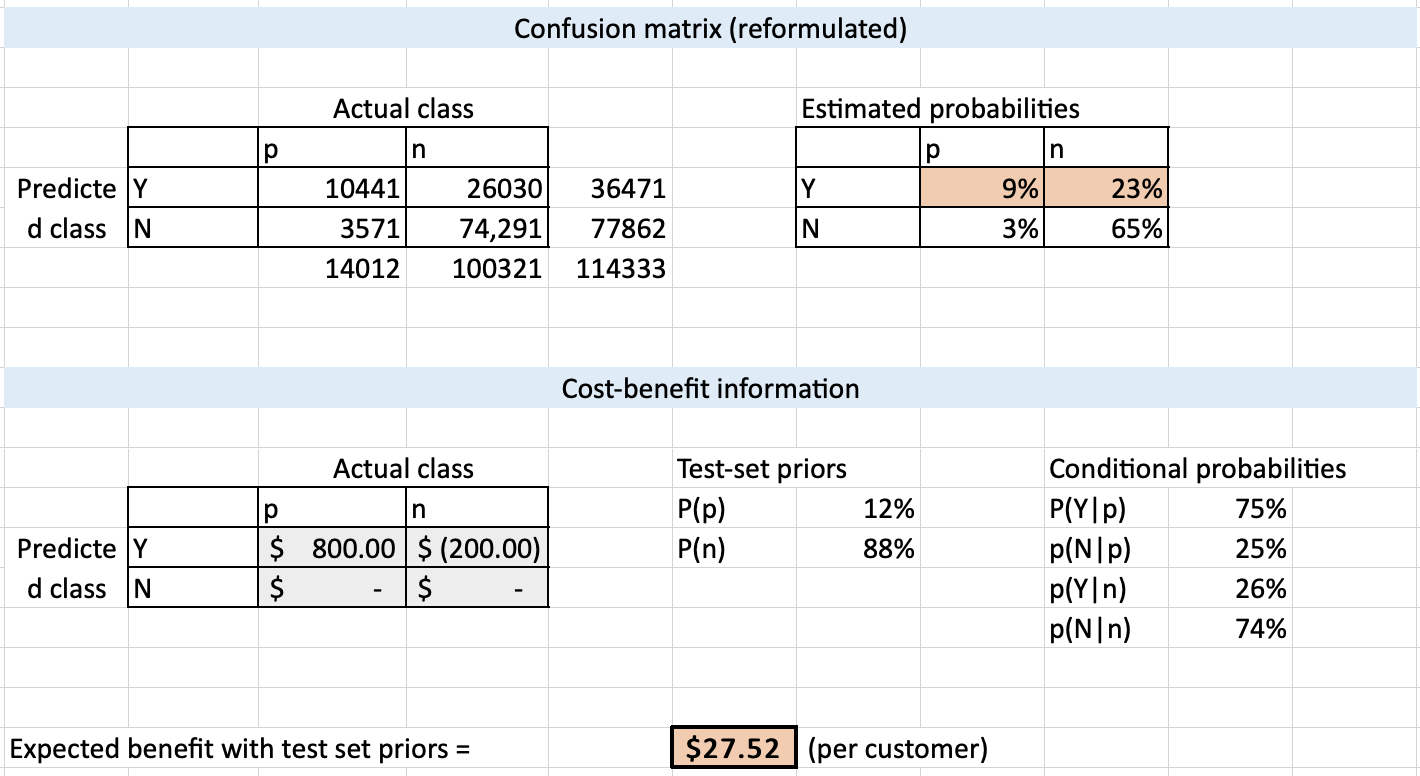

### 7.3.2 Cost-Benefit Analysis for Decision Tree 

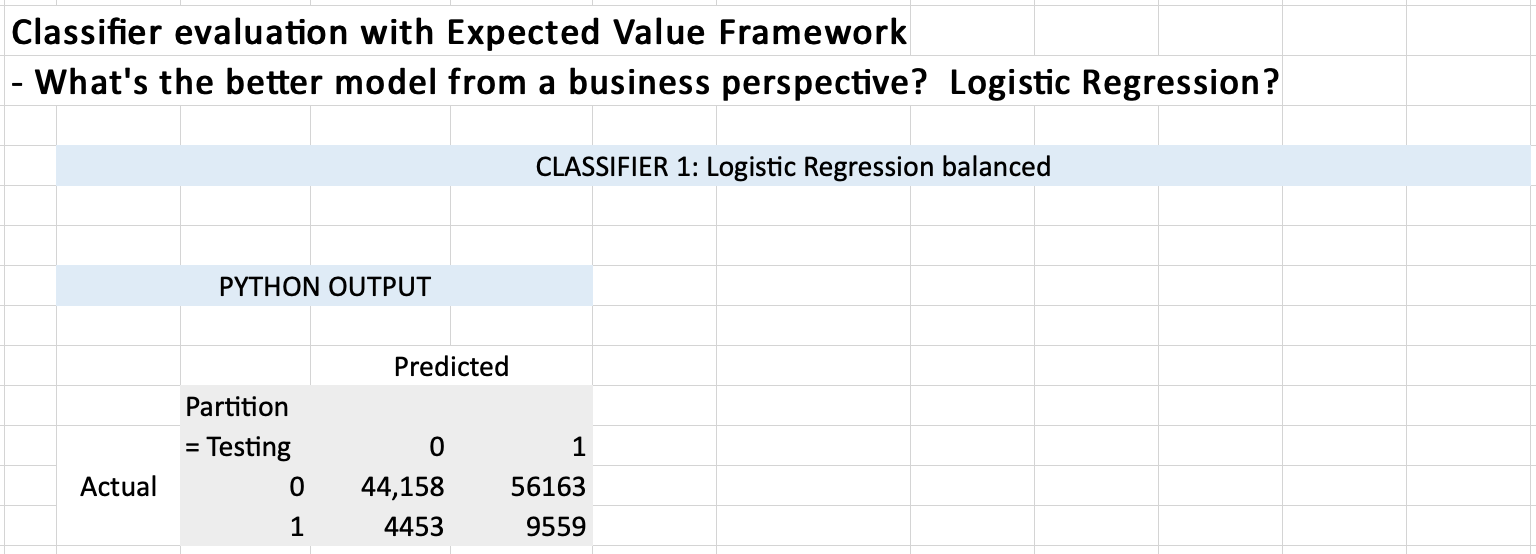

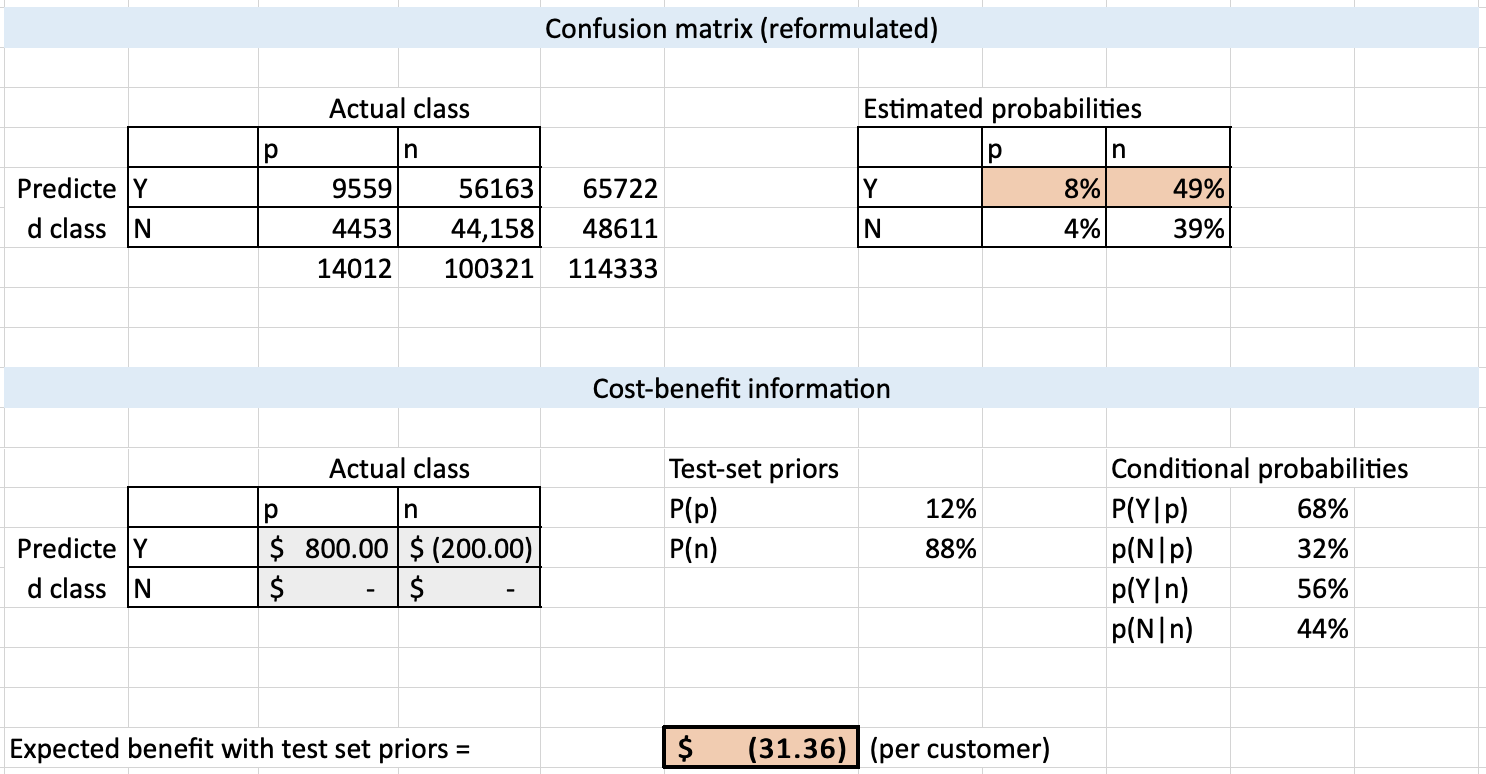

### 7.3.3 Cost-Benefit Analysis for Decision Tree 

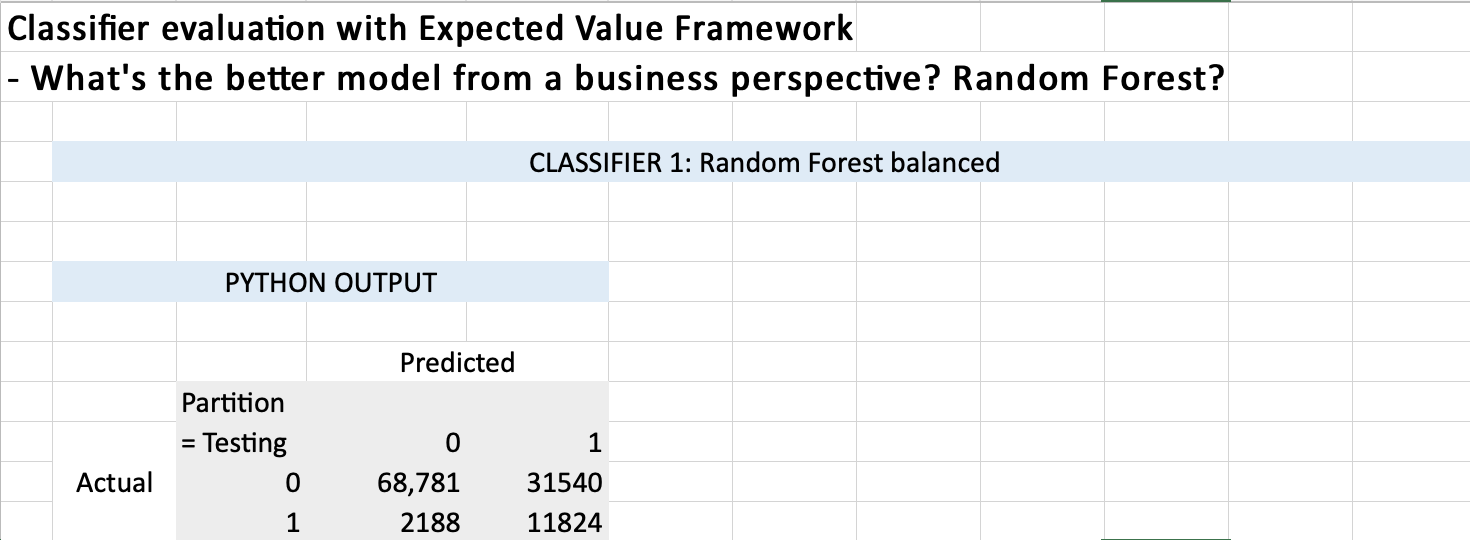

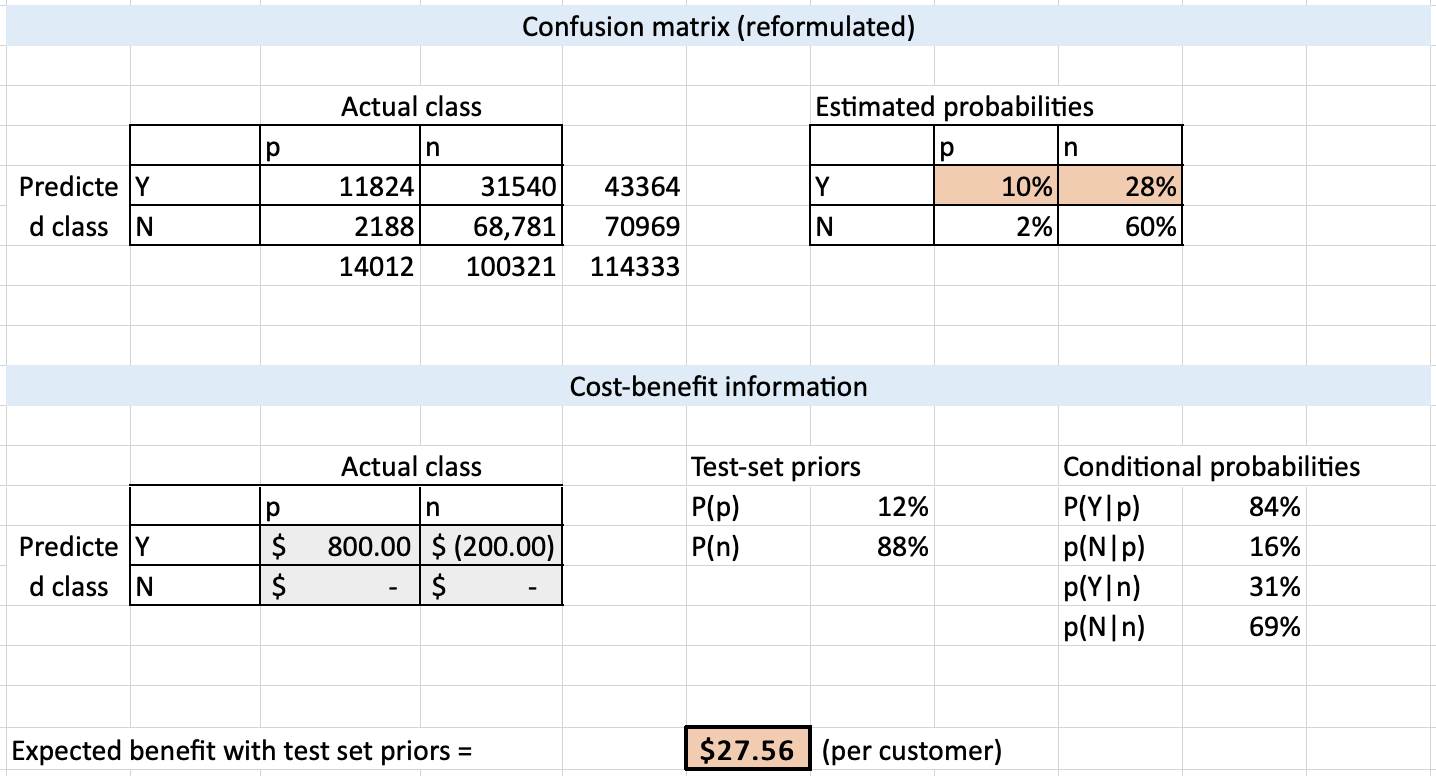

<a id='conclusion'></a>
## 8. Conclusion

**Exploratory analysis**
- Age: Customers whose ages are between 30 and 60 are more likely to response. Customer whose ages are between 20 and 30 are less likely to response.
- Vehicle damage: Customers who experienced vehicle damage before are more willing to response. 
- Vehicle age: The older a vehicle is, the more likely its owner is to response.
- Gender: Male customers are more willing to response our car insurance than female customers. 
- Annual premium: Annual_Premium has a long-tailed distribution, with a lot of observations on the low value end, and few on the high value end. I did not find clear clues to explain the distribution of Annual_Premium.
- Vintage: I did not find clear clues to explain the distribution of Vintage. 
- ID: No explanatory power
- Driving_License: It’s quite obvious assumption that people who don’t have driving license would not be interested in vehicle insurance, Also, I can see from the data that almost all of respondent has a driving license.
- Region_code and Policy_Sales_Channel: If using one hot encoding, it will add 208 new columns to dataset. I also considered some solutions (e.g divide 'Region_code' values into groups like 'northern' or 'southern’). However, due to limited background information about the company and these features, I don’t have any evidence to combine these numbers with “meaningful” staffs. Dropping them is the optimal choice. 

**Build predictive model**:
- The relative importance of features varies, but the difference is minor: 
> For both Logistic Regression and Random Forest: "Previously_insured" , "Vehicle_Damage", and “Vehicle_Age” are the top 3 significant features. 
> For Decision Tree: “Previously_insured" and “Vehicle_Age”  are the top 2 significant features, but ”Age” is the 3rd significant feature. 

- Conclusions: 
> We can basically conclude that the 3 main factors on customer's response are: "Vehicle_Damage", "Previously_insured" and "Vehicle_Age", which are coherent with our previous EDA findings.
> The attributes "Annual_Premium" and "Vintage" are less significant in our response prediction.


**Model evaluation**
- I evaluate our model performance from three indicators: Accuracy, AUC score and Gini index.

> Although the Random Forest has highest AUC & Gini, the difference between its scores and other's is not too large. So, Decision Tree is still the optimal option by its highest accuracy rate and simplicity in result interpretation. 

- Based on result of Cost-Benefit analysis (built on Excel file): 
> The performance of Decision Tree and Random Forest are pretty similar. In contrast, the Logistics Regression seems like not a good choice.



**Implications from Decision Tree model**
- Marketing of vehicle insurance should target customers with the following three attributes (from result of Decision Tree Model):
> Have not been previously insured,
> Have vehicle age more than 1 year and,

- Based on above results, the company can:
> Utilize social media (effectively attracts attention from young consumers) 
> Cooperate with vehicle repair shops (as they can assess conditions of vehicle, then help promote new products on right customer group)
